In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical

In [2]:
# Function 1: Load Images from Train Folder
def load_images_from_folder(folder_path, target_size=(224, 224)):
    images = []
    labels = []
    
    for subdir, _, files in os.walk(folder_path):
        label = os.path.basename(subdir)  # Folder name as label (disease type)
        for file in files:
            image_path = os.path.join(subdir, file)
            image = cv2.imread(image_path)
            if image is not None:
                image = resize_image(image)
                images.append(image)
                labels.append(label)
    
    return np.array(images), labels

In [3]:
# Function 2: Resize Image
def resize_image(image, size=(224, 224)):
    return cv2.resize(image, size, interpolation=cv2.INTER_AREA)

In [4]:
# Function 3: Remove Noise and Blur
def remove_noise(image):
    return cv2.fastNlMeansDenoisingColored(image, None, 10, 10, 7, 21)

In [5]:
# Function 4: Convert to Grayscale
def convert_to_grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

In [6]:
# Function 5: Disease Segmentation (Outer Edge Detection)
def detect_outer_edges(image):
    gray = convert_to_grayscale(image)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    
    _, binary = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    kernel = np.ones((5,5), np.uint8)
    closed = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel, iterations=2)
    
    contours, _ = cv2.findContours(closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    edge_mask = np.zeros_like(gray)
    cv2.drawContours(edge_mask, contours, -1, (255), 2)
    
    return gray, edge_mask, contours

In [7]:
# Function 2: Detect Edges on Original Image (Without Grayscale Conversion)
def detect_edges_on_original(image):
    # Apply GaussianBlur to reduce noise
    blurred = cv2.GaussianBlur(image, (5, 5), 0)
    
    # Convert to grayscale for edge detection (but don't alter the original image)
    gray = cv2.cvtColor(blurred, cv2.COLOR_BGR2GRAY)
    
    # Apply Canny edge detection to the original (colored) image
    edges = cv2.Canny(image, 100, 200)  # Adjust threshold values as necessary
    
    # Create a blank image for the original contours
    edge_mask = np.zeros_like(image)
    
    # Draw the contours on the original image (using green color for visibility)
    edge_mask[edges != 0] = [0, 255, 0]  # Green color for edges
    
    return gray, edge_mask

In [8]:
# Function 6: Display All Images (Original, Grayscale, Contours on Grayscale, Contours on Original)
def display_images(original, grayscale, contours_gray, contours_original):
    plt.figure(figsize=(16, 8))
    
    # Original Image
    plt.subplot(1, 4, 1)
    plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
    plt.title("Original Image")
    
    # Grayscale Image
    plt.subplot(1, 4, 2)
    plt.imshow(grayscale, cmap="gray")
    plt.title("Grayscale Image")
    
    # Contours on Grayscale
    plt.subplot(1, 4, 3)
    plt.imshow(contours_gray, cmap="gray")
    plt.title("Contours on Grayscale")
    
    # Contours on Original Image
    plt.subplot(1, 4, 4)
    plt.imshow(cv2.cvtColor(contours_original, cv2.COLOR_BGR2RGB))
    plt.title("Contours on Original Image")

    plt.show()

In [9]:
# Function 7: Extract Features (Shape, Color, Texture, Diameter, Border)
def extract_features(image, contours):
    features = []
    
    # Feature 1: Shape (Contour Area, Perimeter)
    if len(contours) > 0:
        c = max(contours, key=cv2.contourArea)  # Largest contour
        area = cv2.contourArea(c)
        perimeter = cv2.arcLength(c, True)
    else:
        area, perimeter = 0, 0
    
    features.extend([area, perimeter])

    # Feature 2: Color (Mean Color in HSV)
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    mean_color = np.mean(hsv, axis=(0,1))
    features.extend(mean_color)

    # Feature 3: Texture (Standard Deviation of Gray Image)
    gray = convert_to_grayscale(image)
    texture = np.std(gray)
    features.append(texture)

    # Feature 4: Diameter (Bounding Box around lesion)
    if len(contours) > 0:
        x, y, w, h = cv2.boundingRect(c)
        diameter = max(w, h)
    else:
        diameter = 0
    features.append(diameter)

    return features

In [14]:
# Function 8: Process and Cluster Data
def process_and_cluster(folder_path, num_clusters=7):
    images, labels = load_images_from_folder(folder_path)
    
    feature_list = []
    clustered_images = {i: [] for i in range(num_clusters)}  # Store clustered images

    print("Processing images...")
    for image in tqdm(images):
        image = resize_image(image)
        image = remove_noise(image)
        gray, edge_mask, contours = detect_outer_edges(image)
        features = extract_features(image, contours)
        feature_list.append(features)

    # Normalize & Cluster Data
    feature_array = np.array(feature_list)
    scaler = StandardScaler()
    feature_array = scaler.fit_transform(feature_array)

    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    clusters = kmeans.fit_predict(feature_array)

    # Store images in respective clusters
    for i, image in enumerate(images):
        clustered_images[clusters[i]].append(image)

    print("Clustering complete!")
    return clustered_images, feature_array, clusters

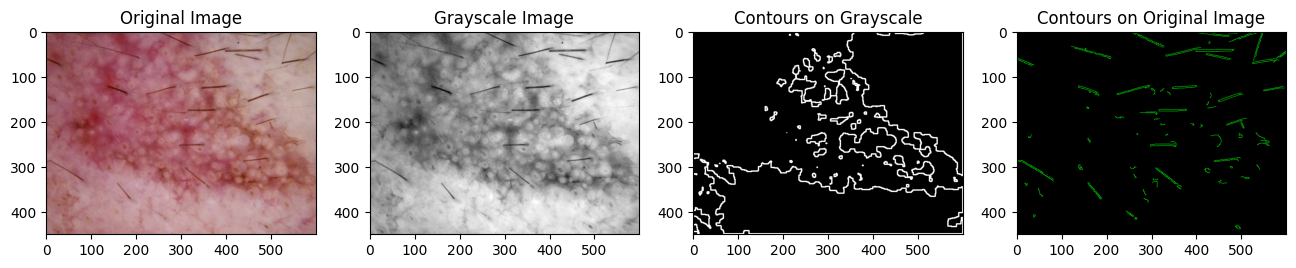

In [29]:
image = cv2.imread("/kaggle/input/skin-cancer9-classesisic/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/ISIC_0025780.jpg")
# Detect edges on grayscale image
grayscale, contours, _ = detect_outer_edges(image)

# Detect edges on original image
grayscale_for_original, edges_original = detect_edges_on_original(image)

# Display images
display_images(image, grayscale, contours, edges_original)

In [12]:
# **Main Execution**
folder_path = "/kaggle/input/skin-cancer9-classesisic/"  # Change this to match Kaggle dataset path

In [15]:
# Process and cluster images
clustered_images, feature_array, clusters = process_and_cluster(folder_path)

Processing images...


100%|██████████| 4714/4714 [12:56<00:00,  6.07it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Clustering complete!


In [16]:
clusters

array([4, 5, 4, ..., 6, 0, 2], dtype=int32)

In [25]:
len(clustered_images)

7

In [26]:
for cluster_id, images in clustered_images.items():
    print(f"Cluster {cluster_id}: {len(images)} images")

Cluster 0: 540 images
Cluster 1: 626 images
Cluster 2: 918 images
Cluster 3: 100 images
Cluster 4: 882 images
Cluster 5: 1150 images
Cluster 6: 498 images


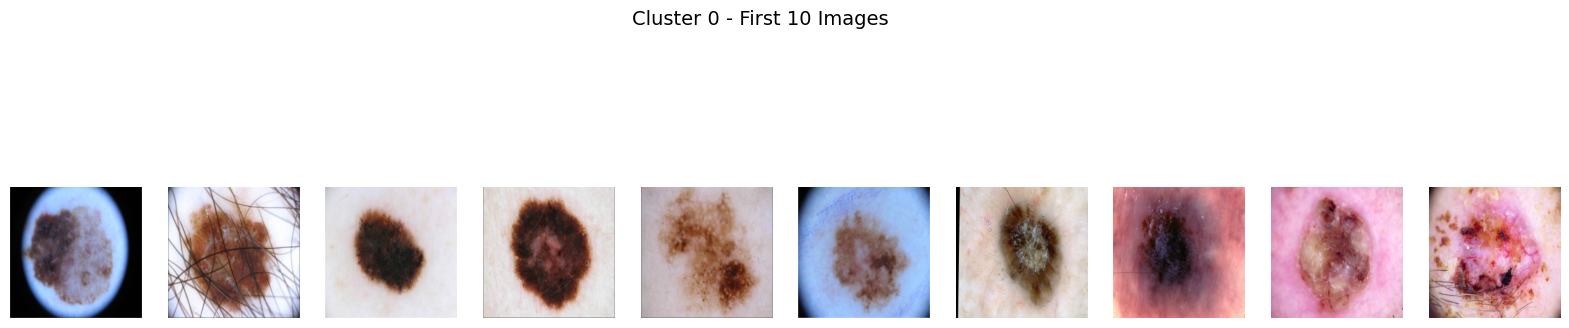

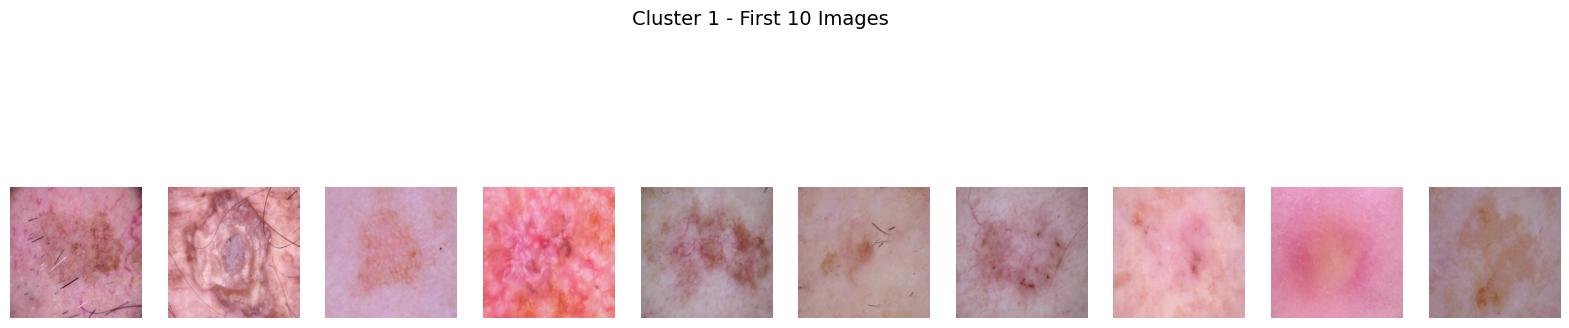

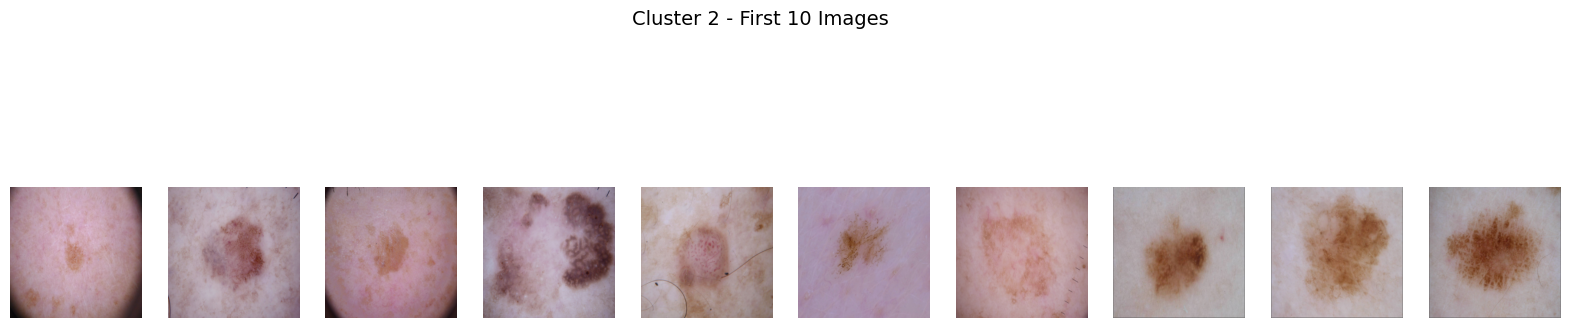

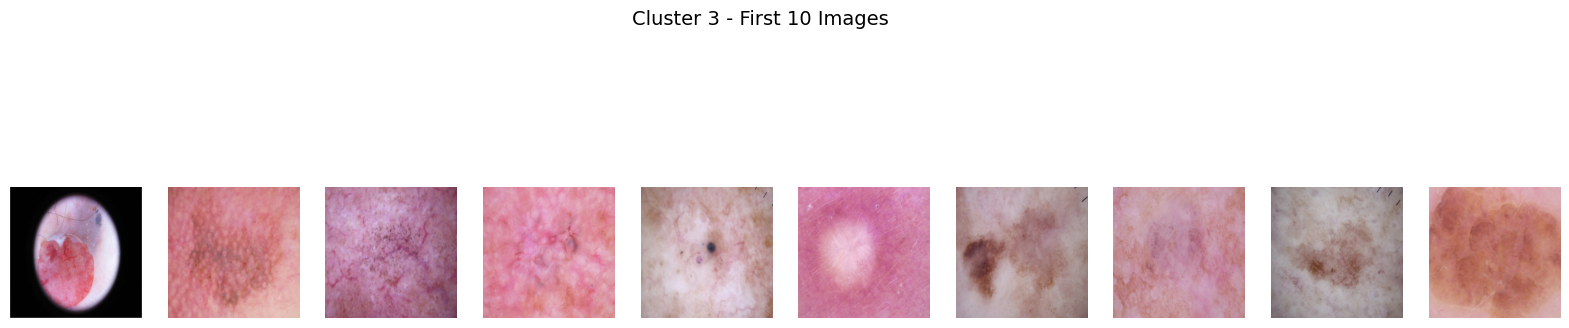

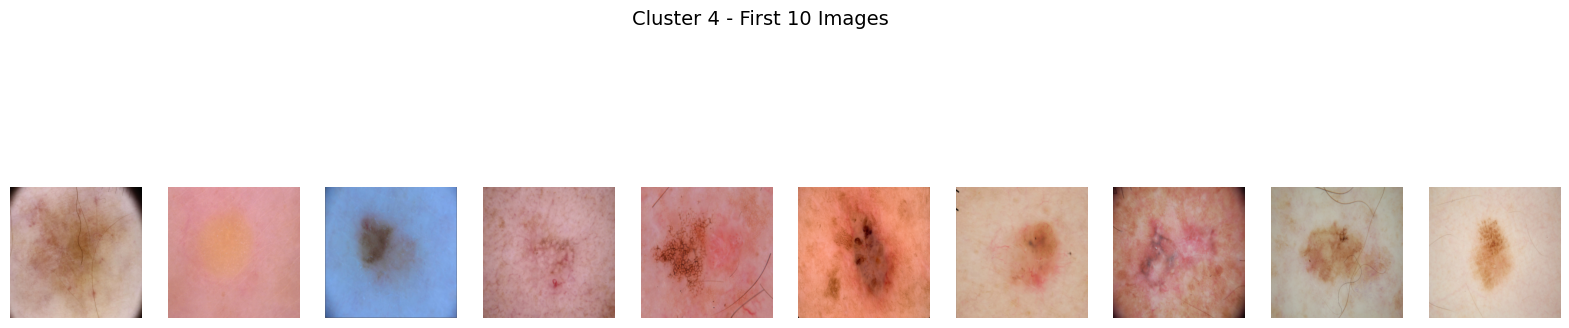

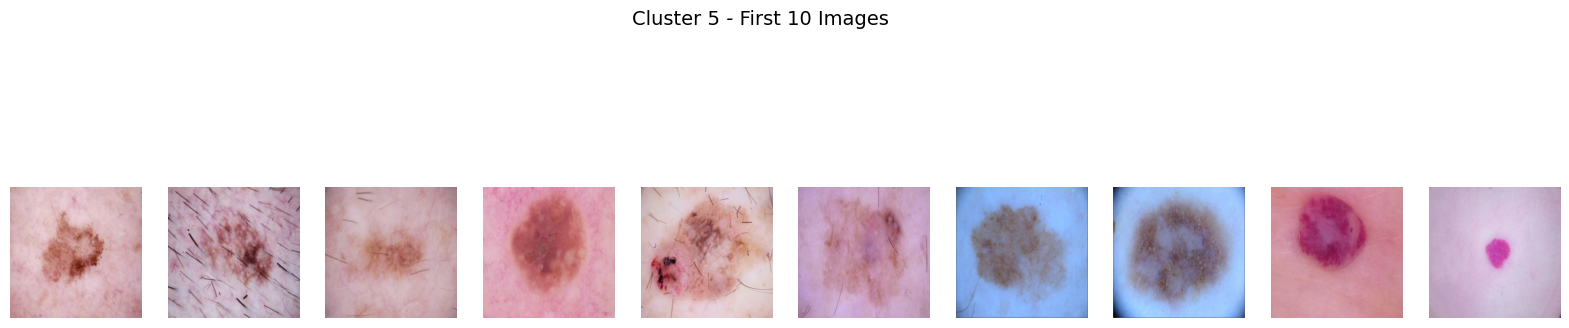

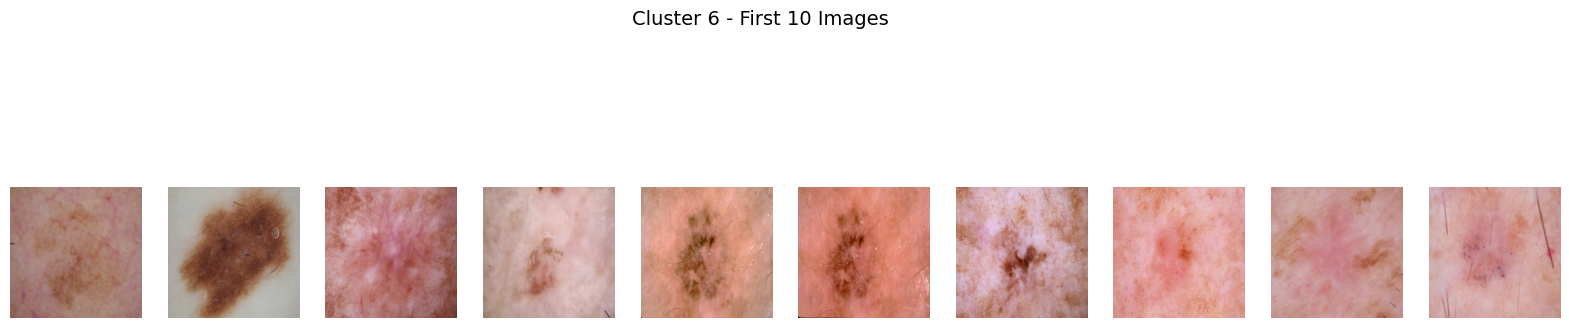

In [28]:
def print_ten_images_per_cluster(clustered_images):
    for cluster_id, images in clustered_images.items():
        num_images = min(10, len(images))  # Get up to 10 images per cluster
        
        if num_images > 0:
            plt.figure(figsize=(20, 5))  # Adjust figure size for 10 images
            
            for i in range(num_images):
                plt.subplot(1, 10, i + 1)  # Create 10 subplots in a row
                plt.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))  # Convert BGR to RGB
                plt.axis('off')
            
            plt.suptitle(f"Cluster {cluster_id} - First {num_images} Images", fontsize=14)
            plt.show()

# Call the function to display images
print_ten_images_per_cluster(clustered_images)


In [11]:
# Function 9: Train CNN Model
def train_cnn_model(images, labels):
    # Convert labels to one-hot encoding
    labels_set = list(set(labels))
    label_to_index = {label: idx for idx, label in enumerate(labels_set)}
    y_train = np.array([label_to_index[label] for label in labels])
    y_train = to_categorical(y_train, num_classes=len(labels_set))
    
    # Normalize images
    images = images / 255.0  # Normalize to the range [0, 1]

    # Create CNN model
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
        layers.MaxPooling2D((2, 2)),
        
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(len(labels_set), activation='softmax')
    ])
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.fit(images, y_train, epochs=10, batch_size=32, validation_split=0.2)
    
    return model

In [ ]:
# Train CNN on clustered images
model = train_cnn_model(clustered_images, num_clusters=7, labels=clusters)